### This file contains the code to train the ResNet50 on our own Dataset.

In [3]:
# Importing the required libraries
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Input
from tensorflow.keras.optimizers import Adam
import os
import PIL
from pathlib import Path

Definition and Verification of Dataset Directory

c:\Users\anaki\Documents\College Files\3rd Year\Second Semester\CMSC 191\Activities\Final Project\model_training\image_data\afritada\afritada_0.jpg


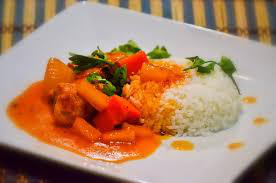

In [4]:
data_dir = Path(os.path.abspath('image_data'))

# Get a list of image files in the specified directory
image_list = list(data_dir.glob('afritada/*'))

print(image_list[0])
PIL.Image.open(str(image_list[0]))


Dataset Preparation

In [ ]:
# Image Resize
img_height, img_width = 215, 215
batch_size = 16

In [5]:
# Generate Dataset for Training following 80/20 split (80% training, 20% validation)
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 3440 files belonging to 30 classes.
Using 2752 files for training.


In [6]:
# Generate Dataset for Validation following 80/20 split (80% training, 20% validation)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 3440 files belonging to 30 classes.
Using 688 files for validation.


In [7]:
# Save the class names to a JSON file, which will be used in the actual application
import json

class_names = train_ds.class_names
print(class_names)


# Save the class names to a file
with open('class_names.json', 'w') as f:
    json.dump(class_names, f)

['afritada', 'arroz_caldo', 'balut', 'bibingka', 'bicol_express', 'bistek_talagog', 'bulalo', 'cassava_cake', 'champorado', 'chicharon', 'chicken_inasal', 'crispy_pata', 'filipino_spaghetti', 'halo-halo', 'kare-kare', 'kinilaw', 'leche_flan', 'lechon', 'lechon_kawali', 'longganisa', 'lumpia', 'pancit_guisado', 'pancit_palabok', 'pandesal', 'pinakbet', 'pork_adobo', 'pork_barbecue', 'pork_sisig', 'tinola', 'tocino']


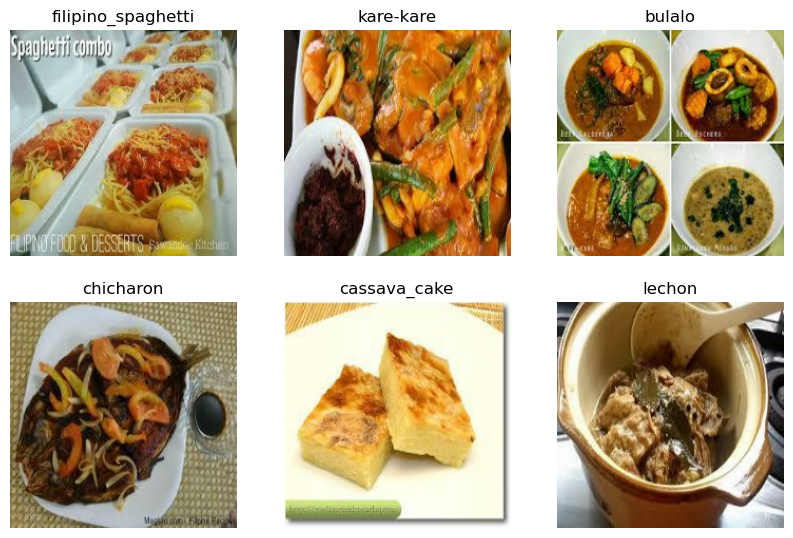

In [6]:
# Visualize some of the images in the dataset
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(6):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

Data Augmentation

In [17]:
"""
    Applied augmentation techniques:
        -> Horizontal and Vertical Flip
        -> Random Rotation
        -> Random Zoom
"""
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
    layers.experimental.preprocessing.RandomZoom(0.2),
])

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_14 (Sequential)   (None, 215, 215, 3)       0         
_________________________________________________________________
resnet50 (Functional)        (None, 2048)              23587712  
_________________________________________________________________
flatten_5 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dense_10 (Dense)             (None, 512)               1049088   
_________________________________________________________________
dense_11 (Dense)             (None, 33)                16929     
Total params: 24,653,729
Trainable params: 1,066,017
Non-trainable params: 23,587,712
_________________________________________________________________


Initialize ResNet50 that is Pretrained on the Imagenet Dataset

In [ ]:
# Define the pretrained ResNet50 model
pretrained_model = tf.keras.applications.ResNet50(
    include_top=False,
    input_shape=(215, 215, 3),
    pooling='avg',
    weights='imagenet'
)

# Freeze the layers in the pretrained model
for layer in pretrained_model.layers:
    layer.trainable = False

# Create the Sequential model
resnet_model = Sequential()

# Add an input layer to specify the input shape
resnet_model.add(Input(shape=(215, 215, 3)))

# Add the data augmentation layer
resnet_model.add(data_augmentation)

# Add the pretrained ResNet50 model
resnet_model.add(pretrained_model)

# Add the rest of the layers
resnet_model.add(Flatten())
resnet_model.add(Dense(512, activation='relu'))
resnet_model.add(Dense(33, activation='softmax')) 

# Print the model summary
resnet_model.summary()

Configure the training process for the model.

In [18]:
resnet_model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

Model Training

In [19]:
# No. of epochs
epochs=7

# Train the model
history = resnet_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/7
172/172 [==============================] - 38s 113ms/step - loss: 2.9104 - accuracy: 0.2217 - val_loss: 2.5364 - val_accuracy: 0.3154
Epoch 2/7
172/172 [==============================] - 17s 102ms/step - loss: 2.2486 - accuracy: 0.3805 - val_loss: 2.4875 - val_accuracy: 0.3445
Epoch 3/7
172/172 [==============================] - 19s 109ms/step - loss: 2.0702 - accuracy: 0.4211 - val_loss: 2.3384 - val_accuracy: 0.3924
Epoch 4/7
172/172 [==============================] - 19s 109ms/step - loss: 1.8974 - accuracy: 0.4618 - val_loss: 2.4029 - val_accuracy: 0.3953
Epoch 5/7
172/172 [==============================] - 19s 111ms/step - loss: 1.7543 - accuracy: 0.5087 - val_loss: 2.4377 - val_accuracy: 0.3750
Epoch 6/7
172/172 [==============================] - 17s 96ms/step - loss: 1.6602 - accuracy: 0.5356 - val_loss: 2.4646 - val_accuracy: 0.3765
Epoch 7/7
172/172 [==============================] - 16s 94ms/step - loss: 1.5293 - accuracy: 0.5640 - val_loss: 2.4944 - val_accuracy: 0

In [20]:
# Save the model
resnet_model.save('models/resnet_model.h5')

c:\Users\anaki\anaconda3\envs\comvision_final\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Model Accuracy and Loss Curve Visualization

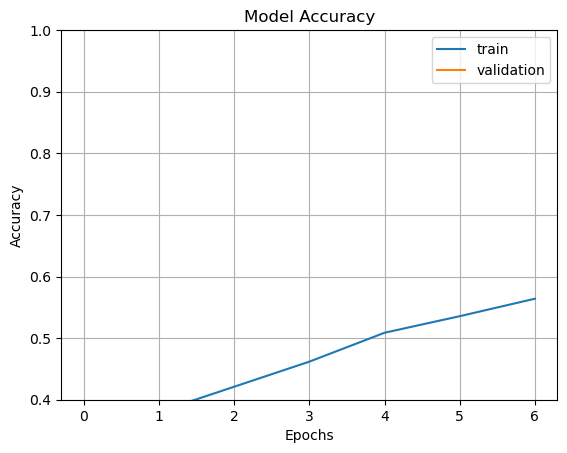

In [21]:
fig1 = plt.gcf()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.axis(ymin=0.4,ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

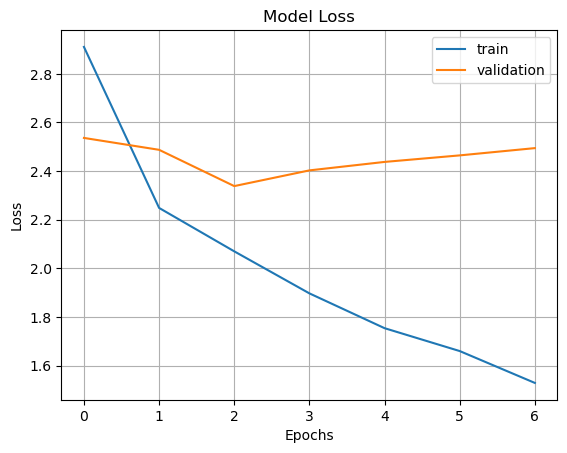

In [22]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.grid()
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

Model Testing

In [8]:
import cv2

# If you want to test your own data, change the path to the image file
image=cv2.imread('C:\\Users\\anaki\\Documents\\College Files\\3rd Year\\Second Semester\CMSC 191\Activities\images\\lumpia\\lumpia_322.jpg')
image_resized= cv2.resize(image, (img_height,img_width))
image=np.expand_dims(image_resized,axis=0)
print(image.shape)


new_model = tf.keras.models.load_model('models/resnet_model.h5')
pred=new_model.predict(image)
confidence_level = np.max(pred)
print(pred)
print("Confidence Level:", confidence_level)

output_class=class_names[np.argmax(pred)]
print("The predicted class is", output_class)


(1, 215, 215, 3)
[[3.8682638e-06 5.1679208e-09 2.4610490e-06 4.1398625e-06 5.1649597e-05
  9.7088048e-07 9.9588382e-10 1.7614376e-06 4.5637677e-07 8.7377999e-04
  1.1286518e-04 5.1363591e-06 2.7083095e-07 1.0474600e-06 6.6634002e-06
  2.0608979e-05 3.5007273e-05 6.9184636e-05 1.1268391e-03 9.6334904e-02
  8.9994705e-01 5.4278371e-07 8.7654712e-07 1.5761383e-04 2.4813342e-05
  7.1521561e-07 1.1490564e-03 2.7850516e-05 9.9323234e-09 3.9907114e-05
  2.0513677e-13 8.7631540e-13 5.3644828e-11]]
Confidence Level: 0.89994705
The predicted class is lumpia
